# Minerva: AI Guardian for Scam Protection

This notebook implements a multi-agent system for analyzing images (screenshots) to identify scam attempts, and provide personalized scam prevention. It uses [AutoGen](https://github.com/microsoft/autogen/) to orchestrate various specialized agents that work together.

Benefits:
- Automates the process of identifying suspicious scam patterns.
- Prevent Financial Loss
- Save Time: Early scam detection reduces the number of claims filed by end-users.

## Install Dependencies

In [103]:
%pip install -q autogen-agentchat~=0.2 pillow pytesseract pyyaml

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import autogen

from IPython.display import Image as IPImage
from IPython.display import display

In [106]:
import os
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

config_list = [
    {
        "model": "gpt-4o-mini",
        "api_key": os.getenv("OPENAI_API_KEY")
    }
]

llm_config = {
    "config_list": config_list,
    "timeout": 120,
}

In [107]:
import yaml

with open('config/agents.yaml', 'r') as file:
    config = yaml.safe_load(file)

## Agents Creation

In [108]:
def create_agents():

    ocr_agent = autogen.AssistantAgent(
        name="OCR_Specialist",
        system_message=config['ocr_agent']['assignment'],
        llm_config=llm_config
    )
   
    content_agent = autogen.AssistantAgent(
        name="Content_Analyst",
        system_message=config['content_agent']['assignment'],
        llm_config=llm_config
    )

    decision_agent = autogen.AssistantAgent(
        name="Decision_Maker",
        system_message=config['decision_agent']['assignment'],
        llm_config=llm_config
    )

    summary_agent = autogen.AssistantAgent(
        name="Summary_Agent",
        system_message=config['summary_agent']['assignment'],
        llm_config=llm_config
    )

    user_proxy = autogen.UserProxyAgent(
        name="user_proxy",
        is_termination_msg=lambda x: "TASK_COMPLETE" in x.get("content", ""),
        human_input_mode="NEVER",
        max_consecutive_auto_reply=10,
    )

    @user_proxy.register_for_execution()
    @ocr_agent.register_for_llm(description="Extracts text from an image path")
    def ocr(image_path: str) -> str:
        from PIL import Image
        import pytesseract

        try:
            image = Image.open(image_path)
            text = pytesseract.image_to_string(image)
            return text
        except Exception as e:
            return f"Error in text extraction: {str(e)}"
    
    return ocr_agent, content_agent, decision_agent, user_proxy 

## Workflow

In [109]:
class ScamDetectionWorkflow:
    def __init__(self):
        self.ocr_agent, self.content_agent, self.decision_agent, self.user_proxy = create_agents()
        
    def analyze(self, image_path):
        """Coordinate the multi-agent analysis.
        """
        image_path = "./samples/02.giftcard.message.scam.png"
        
        groupchat = autogen.GroupChat(
            agents=[self.ocr_agent, self.content_agent, self.decision_agent, self.user_proxy],
            messages=[],
            max_round=15,
        )
        manager = autogen.GroupChatManager(groupchat=groupchat)

        # Start the collaborative analysis
        messages = self.user_proxy.initiate_chat(
            manager,
            message=f"""
            1. OCR Agent: Extract text from this image: {image_path}
            2. Content Agent: Evaluate the messaging and claims
            3. Decision Maker: Synthesize all analyses and make final determination""",
        )

        return messages

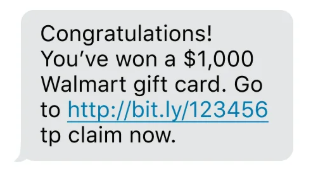

user_proxy (to chat_manager):


            1. OCR Agent: Extract text from this image: ./samples/02.giftcard.message.scam.png
            2. Content Agent: Evaluate the messaging and claims
            3. Decision Maker: Synthesize all analyses and make final determination

--------------------------------------------------------------------------------

Next speaker: OCR_Specialist

OCR_Specialist (to chat_manager):

***** Suggested tool call (call_u8NqTuVd9I0eMW0FEyuggyxJ): ocr *****
Arguments: 
{"image_path":"./samples/02.giftcard.message.scam.png"}
********************************************************************

--------------------------------------------------------------------------------

Next speaker: user_proxy


>>>>>>>> EXECUTING FUNCTION ocr...
user_proxy (to chat_manager):

***** Response from calling tool (call_u8NqTuVd9I0eMW0FEyuggyxJ) *****
Congratulations!
You've won a $1,000
Walmart gift card. Go

http://bit.ly/123456
tp claim now.

***************************

In [110]:
image_path = "./samples/02.giftcard.message.scam.png"
display(IPImage(filename=image_path))

workflow = ScamDetectionWorkflow()
results = workflow.analyze(image_path)

In [111]:
import pprint

pprint.pprint(results.chat_history[-1])

{'content': 'Based on the analyses provided from both the OCR extraction and '
            'content evaluation, I have reached a final determination '
            'regarding the probability that this message is a scam.\n'
            '\n'
            '### Final Determination:\n'
            'The message purporting to inform the recipient of a $1,000 '
            'Walmart gift card win is unequivocally a scam.\n'
            '\n'
            '### Detailed Explanation:\n'
            '\n'
            '1. **Classic Scam Traits:**\n'
            '   - The claim of winning a prize, especially of such an amount, '
            'is a hallmark of scams. Organizations do not randomly award gift '
            'cards without a proper contest or registration process.\n'
            '\n'
            '2. **Urgent Call to Action:**\n'
            '   - The phrase "to claim now" creates a sense of urgency that is '
            'typically designed to prevent the target from thinking critically '
      

In [112]:
import json


with open('results.json', 'w') as json_file:
    json.dump(results.__dict__, json_file, indent=4)